In [225]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, InputLayer
from tensorflow.keras import optimizers
import tensorflow.keras.backend as K
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import nasnet, resnet50, densenet
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import json

%matplotlib inline

In [226]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

In [227]:
val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

In [228]:
train_gen = train_datagen.flow_from_directory(
        'data/train',
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical',
        shuffle=True)

val_gen = val_datagen.flow_from_directory(
        'data/validation',
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

test_gen = test_datagen.flow_from_directory(
        'data/test',
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

Found 1052 images belonging to 2 classes.
Found 204 images belonging to 2 classes.
Found 697 images belonging to 2 classes.


In [229]:
batch = train_gen.next()  # this will read in 32 images from the train directory

In [230]:
batch[0][0]               # this is one 150,150,3 color photo

array([[[0.3249565 , 0.28662258, 0.08339709],
        [0.31567165, 0.24635164, 0.07386108],
        [0.27583155, 0.24553137, 0.09345678],
        ...,
        [0.14128217, 0.12072035, 0.0509804 ],
        [0.13650134, 0.11474431, 0.0509804 ],
        [0.1317205 , 0.10876827, 0.0509804 ]],

       [[0.32372507, 0.29647404, 0.11295149],
        [0.31936598, 0.2598974 , 0.07262965],
        [0.29060876, 0.24306849, 0.08606818],
        ...,
        [0.13133611, 0.10684453, 0.05001822],
        [0.13372654, 0.10803974, 0.04882301],
        [0.13611695, 0.10923494, 0.0476278 ]],

       [[0.32249367, 0.3063255 , 0.14250588],
        [0.32306027, 0.27344316, 0.07139822],
        [0.30538595, 0.24060562, 0.07867958],
        ...,
        [0.14598832, 0.11465582, 0.04996996],
        [0.15674517, 0.12063186, 0.05355558],
        [0.16750205, 0.1266079 , 0.05714121]],

       ...,

       [[0.21002121, 0.25993815, 0.08149397],
        [0.17709588, 0.24067467, 0.06337038],
        [0.1806815 , 0

In [231]:
batch[1][0]               # this is the one-hot encoded label for this photo

array([0., 1.], dtype=float32)

In [232]:
labels = {}
labels[0] = 'healthy'
labels[1] = 'disease'
labels

{0: 'healthy', 1: 'disease'}

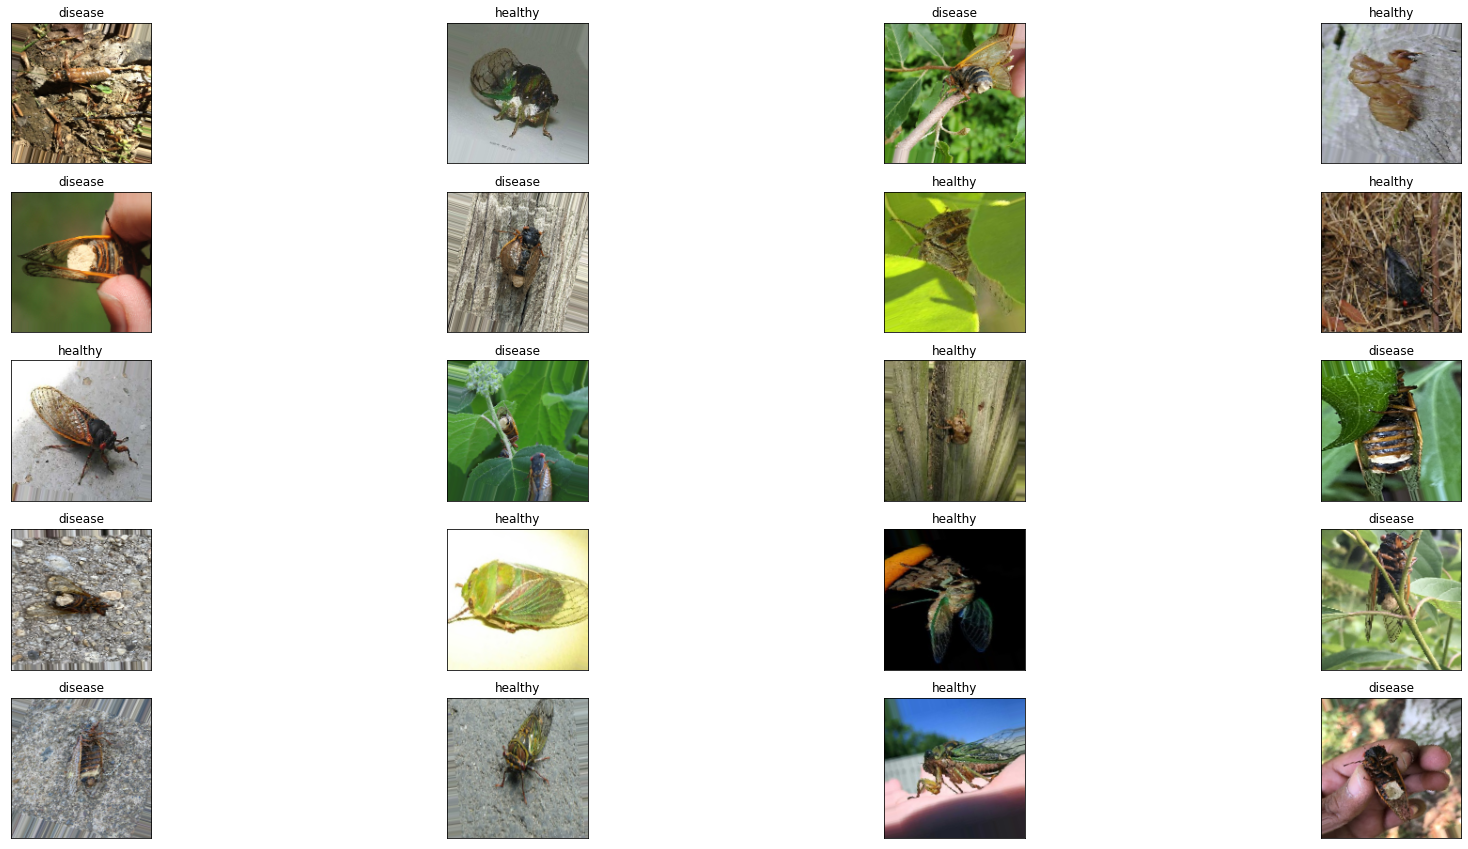

In [233]:
labels = {0: 'healthy', 1: 'disease'}

fig = plt.figure(figsize=(30,15))

for i in range(1,21):
   plt.subplot(5,4, i)
   img = batch[0][i].squeeze()
   label_ind = list(batch[1][i]).index(1)
   title_obj = plt.title(labels[label_ind])
   plt.imshow(img)
   plt.xticks([])
   plt.yticks([])

In [234]:
train_batches = int(train_gen.samples / train_gen.batch_size) * 2
val_batches = int(val_gen.samples / val_gen.batch_size)
val_batches = 1

In [235]:
input_shape=(150,150,3)

In [236]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=2)) 
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2)) 
model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=512, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Flatten())
model.add(Dense(1000, activation='relu'))

model.add(Flatten())
model.add(Dense(500, activation='relu'))

model.add(Flatten())
model.add(Dense(200, activation='relu'))

model.add(Flatten())
model.add(Dense(100, activation='relu'))

model.add(Flatten())
model.add(Dense(50, activation='relu'))

model.add(Dropout(0.25))
model.add(Dense(2, activation='sigmoid'))

opt = optimizers.Nadam(learning_rate=0.000001)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['binary_accuracy']) 

model.summary()


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_65 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 18, 18, 128)       0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 18, 18, 256)     

In [237]:
#history = model.fit_generator(generator=train_gen,validation_data=val_gen,verbose=1,epochs=20,steps_per_epoch=train_batches,
#        validation_steps=val_batches)

#history = model.fit(train_gen,validation_data=val_gen,verbose=1,epochs=5,steps_per_epoch=train_batches,
#        validation_steps=val_batches)

#history = model.fit(train_gen,validation_data=val_gen,verbose=1,epochs=5)

#history = model.fit(train_gen,validation_data=val_gen,verbose=1,epochs=5)

history = model.fit(train_gen,validation_data=val_gen,verbose=1, epochs=10)

Epoch 1/10
33/33 [==============================] - 32s 888ms/step - loss: 0.6929 - binary_accuracy: 0.5124 - val_loss: 0.6829 - val_binary_accuracy: 0.9412
Epoch 2/10
33/33 [==============================] - 31s 923ms/step - loss: 0.6860 - binary_accuracy: 0.6759 - val_loss: 0.6682 - val_binary_accuracy: 0.9461
Epoch 3/10
33/33 [==============================] - 30s 903ms/step - loss: 0.6803 - binary_accuracy: 0.6887 - val_loss: 0.6550 - val_binary_accuracy: 0.9461
Epoch 4/10
33/33 [==============================] - 31s 942ms/step - loss: 0.6747 - binary_accuracy: 0.6953 - val_loss: 0.6405 - val_binary_accuracy: 0.9461
Epoch 5/10
33/33 [==============================] - 31s 931ms/step - loss: 0.6677 - binary_accuracy: 0.6934 - val_loss: 0.6221 - val_binary_accuracy: 0.9461
Epoch 6/10
33/33 [==============================] - 32s 971ms/step - loss: 0.6619 - binary_accuracy: 0.6958 - val_loss: 0.6019 - val_binary_accuracy: 0.9461
Epoch 7/10
33/33 [==============================] - 31s 94

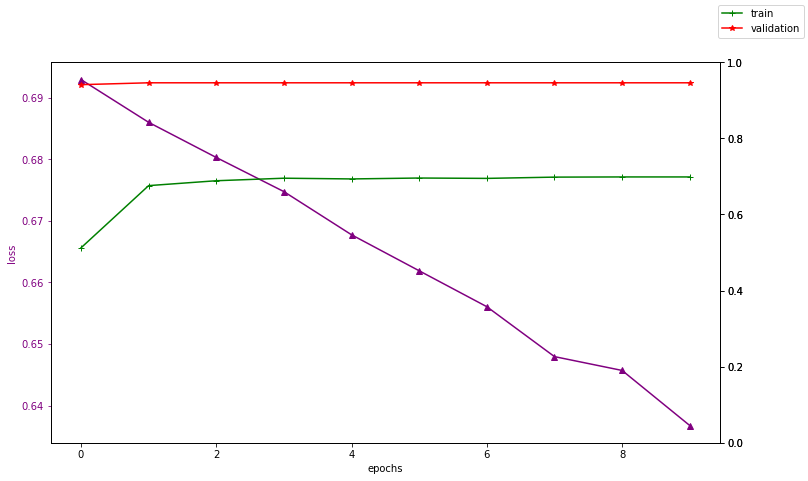

In [238]:
fig, ax1 = plt.subplots(1,1,figsize=(12,7))
ax1.plot(history.epoch, history.history['loss'], marker='^', color='purple')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss', color='purple')
ax1.tick_params('y', colors='purple')

ax2 = ax1.twinx()
plt.plot(history.epoch, history.history['binary_accuracy'], marker='+', color='green', label='train')
ax2.set_ylim(0,1)

ax3 = ax1.twinx()
plt.plot(history.epoch, history.history['val_binary_accuracy'], marker='*', color='red', label='validation')
ax3.set_ylim(0,1)


fig.legend();

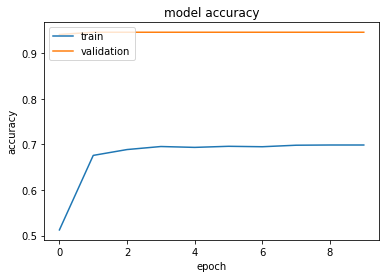

In [239]:
import matplotlib.pyplot as plt


def plot_hist(history):
    plt.plot(history.history["binary_accuracy"])
    plt.plot(history.history["val_binary_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(history)

In [240]:
model.evaluate(test_gen)

22/22 [==============================] - 5s 226ms/step - loss: 0.7055 - binary_accuracy: 0.5395


[0.7054886817932129, 0.5394548177719116]

In [241]:
scores = model.evaluate(test_gen, verbose=0)
print("Test Accuracy: %.2f%%" % (scores[1]*100))

Test Accuracy: 53.95%


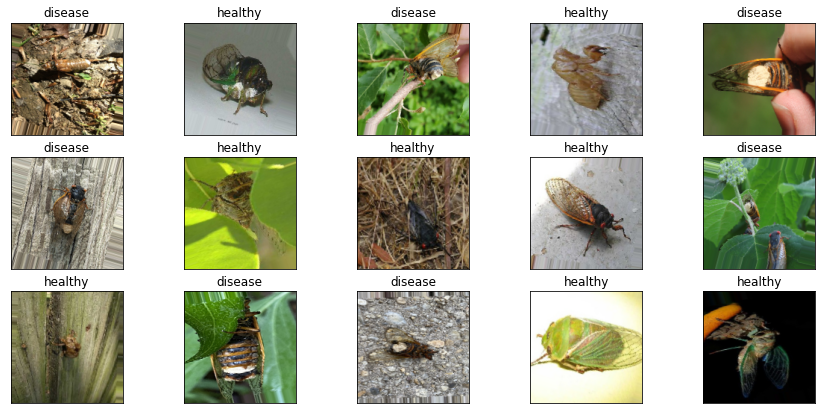

In [242]:
labels = {0: 'healthy', 1: 'disease'}

fig = plt.figure(figsize=(15,7))

for i in range(1,16):
   plt.subplot(3, 5, i)
   img = batch[0][i].squeeze()
   label_ind = list(batch[1][i]).index(1)
   title_obj = plt.title(labels[label_ind])
   plt.imshow(img)
   plt.xticks([])
   plt.yticks([])

In [243]:
scores = model.evaluate(train_gen, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 70.06%


In [244]:
scores = model.evaluate(val_gen, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 94.61%


In [104]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

NameError: name 'cm' is not defined

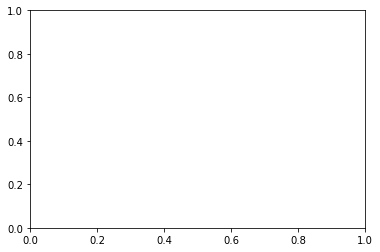

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['business', 'health']); ax.yaxis.set_ticklabels(['health', 'business']);